Código para la estimación de la red con los datos de medidas conectividad wPLI contra los Acc de datos -> standar scaler -> lasso buscando alpha {1e-5,0.2,0.4,0.6,0.8,1} ->LDA

Librerias

In [8]:
import os, sys
from scipy.io import loadmat, savemat
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.metrics import r2_score
from sklearn import linear_model
from scipy.stats import linregress
from scipy.stats import spearmanr, pearsonr
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneOut

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Clase para organizar los datos para la (cross validation)

In [46]:
class feat(BaseEstimator, TransformerMixin):
  def __init__(self):
    self
  # zscore
  def scalerlist(self,Xfull):
     self.scaler = len(Xfull)*[None]
     for i in range(len(Xfull)):
        self.scaler[i] = StandardScaler()
        Xfull[i] = self.scaler[i].fit_transform(Xfull[i])
     return Xfull

  def fit(self,Xepochs,*_):            
      Xfull = [Xepochs[:,:,i] for i in range(Xepochs.shape[2])] 
      self.scalerlist(Xfull)
      return Xfull

  def transform(self,Xepochs,*_):   
      Xfull = [Xepochs[:,:,i] for i in range(Xepochs.shape[2])] 
     
      for i in range(len(Xfull)):
         #self.scaler[i] = StandardScaler()
         Xfull[i] = self.scaler[i].transform(Xfull[i])
      return Xfull

  def fit_transform(self,Xepochs,*_):
      self.fit(Xepochs)
      return self.transform(Xepochs)   

Creamos el modelos con 3 capas para aplicar en el entrenamiento y validación de los datos

In [22]:
class DNN(BaseEstimator, TransformerMixin):
  def __init__(self,epochs=100,batch_size=32,learning_rate=1e-3,optimizer='Adam',
                l1_param=1e-1,l2_param=1e-1,validation_split=0.1,verbose=0,scalex=1,scaley=1,Q1f_=1.5):
        self.epochs = epochs
        self.scalex = scalex
        self.scaley = scaley
        self.batch_size   = batch_size
        self.learning_rate=learning_rate
        self.l1_param =l1_param 
        self.l2_param =l2_param
        self.validation_split = validation_split
        self.verbose  = verbose
        self.optimizer= optimizer
        self.Q1f_ = Q1f_

  def fit(self,X,y,*_):
    #entrenar predictor SMRDNN
    if self.optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    elif self.optimizer == "SGD":
        opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate)
    else:
        opt=self.optimizer

    # Crea sesión
    tf.keras.backend.clear_session()
    seed = 10
    Q1f = self.Q1f_     # número de neuronas para la capa 1
    Qff = 0.5           # número de neuronas para la capa 2
    l1 = self.l1_param  # 
    l2 = self.l2_param  # 
    act1 = 'sigmoid'       # 'relu' 'sigmoid'
    actf = 'sigmoid'       # 'tanh'
    inputs = len(X)*[None]
    hiddens = len(X)*[None]
    winitializer = tf.keras.initializers.GlorotNormal(seed=seed)
    tf.random.set_seed(seed)
    binitializer = "zeros"
    #h1 - capa 1
    for i in range(len(X)):
        inputs[i] = tf.keras.layers.Input(shape=(X[i].shape[1]), name='in_'+str(i))
        hiddens[i] = tf.keras.layers.Dense(int(X[i].shape[1]*Q1f),activation=act1,kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2),kernel_initializer=winitializer,bias_initializer=binitializer,name='h1_'+str(i))(inputs[i])
        # print(hiddens[i].shape)
    
    #concat
    concat = tf.keras.layers.concatenate(hiddens,name='concat')
    
    #concat = tf.keras.layers.concatenate([h1c3psd,h1c4psd],name='concat')
    Qh = np.sum([X[i].shape[1]*Q1f for i in range(len(X))])
    # capa 2
    hfi = tf.keras.layers.Dense(Qh*Qff,activation=actf,kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2),
                              kernel_initializer=winitializer,
                              bias_initializer=binitializer,name='hfi')(concat)
    
    #cla - capa 3
    output_c = tf.keras.layers.Dense(1,activation="linear",kernel_initializer=winitializer, bias_initializer=binitializer,
                                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2),name='outc')(hfi) 
   
    #input_full = [ic3_tuz,ic4_tuz,ic3_tbz,ic4_tbz,ic3_psdz,ic4_psdz]
    self.model_fun = tf.keras.Model(inputs=inputs,outputs=[output_c])

    self.model_fun.compile(loss=tf.keras.losses.mean_squared_error,#self.custom_loss(), mean_squared_error
              optimizer=opt) #f1, precision, recall, crossentropy
    
    self.history = self.model_fun.fit(x=X, y=y,verbose=self.verbose,
                        epochs=self.epochs,batch_size=self.batch_size,validation_split=self.validation_split)
    self.plot_history_acc_w()
    #self.plot_summary()
    return self.model_fun

  def get_capa(self,Name_layer,*_):
    return self.model_fun.get_layer(Name_layer).get_weights()[0]

  def predict(self, X, *_):
    return self.model_fun.predict(X)

  def fit_predict(self,X,y,*_):
      self.fit(X,y)
      return self.predict(X) 

  def plot_history_acc_w(self):    
      hpd = pd.DataFrame(self.history.history)
      #hpd[['loss','val_loss']].plot()
      hpd.plot()
      plt.show()
      return

  #def plot_summary(self):
   #   self.model_fun.summary()
   #   tf.keras.utils.plot_model(self.model_fun)
   #   return

Cargar Datos de los aciertos obtenidos al aplicar CSP+lasso+LDA

In [32]:
X_raw = list() # lista de las bandas.
bands = [2]  # bandas de interes.
# almaceno en una lista cada frecuencia por separado.
for Freq in range(0,len(bands)): # Frecuencia de Analisis
  X_raw.append(loadmat('drive/My Drive/DEEP LEARNING/prueba_deep_cx/Datos/Cx_subs_select.mat')['Cx'][:,:,bands[Freq],:])

(array([6.38180e+04, 1.07137e+05, 9.80050e+04, 5.92460e+04, 2.60320e+04,
        9.12300e+03, 2.82500e+03, 8.75000e+02, 3.42000e+02, 9.70000e+01]),
 array([3.96355134e-07, 9.36902428e-02, 1.87380089e-01, 2.81069936e-01,
        3.74759782e-01, 4.68449628e-01, 5.62139475e-01, 6.55829321e-01,
        7.49519168e-01, 8.43209014e-01, 9.36898860e-01]),
 <a list of 10 Patch objects>)

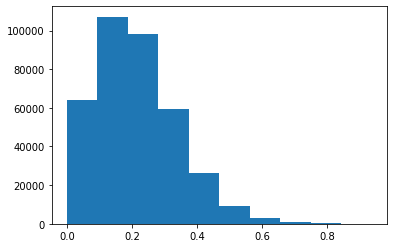

In [17]:
plt.hist(np.concatenate(np.concatenate(X_raw[0])))

In [ ]:
X_raw[0].shape # dimensión de los datos en cada una de las frecuencias.

(50, 210, 35)

In [9]:
zpca = loadmat('drive/My Drive/DEEP LEARNING/Prueba_leave_oneOut/means_acc_daniel2.mat')['Means'][:,0].reshape(-1,1)
zpca = MinMaxScaler().fit_transform(zpca)

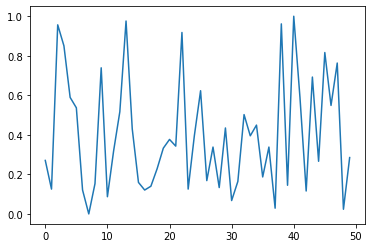

In [10]:
plt.plot(zpca)

In [47]:
feat_ = feat()
train_x = feat_.fit_transform(X_raw[0])
train_x[0].shape
aa = feat_.scalerlist([X_raw[0][:,:,0]])
aa[0].shape 

(50, 210)

In [56]:
data = [[0, 0], [0, 0], [4, 1], [1, 3]]
scaler = StandardScaler()
print(scaler.fit(data))
StandardScaler()
print(scaler.mean_)
print(data)
print(np.var(scaler.transform(data)))

StandardScaler(copy=True, with_mean=True, with_std=True)
[1.25 1.  ]
[[0, 0], [0, 0], [4, 1], [1, 3]]
1.0000000000000002


In [57]:
np.mean(aa[0])

-1.3534147347811432e-17

In [49]:
aa[0] == train_x[0]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

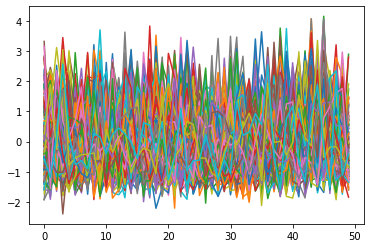

In [48]:
plt.plot(train_x[0])

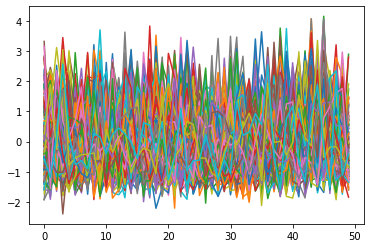

In [45]:
plt.plot(aa[0])

Creamos cv

Epoch 1/150
3/3 [==============================] - 1s 306ms/step - loss: 1625.9851 - val_loss: 1568.7354
Epoch 2/150
3/3 [==============================] - 0s 22ms/step - loss: 1509.3717 - val_loss: 1421.7517
Epoch 3/150
3/3 [==============================] - 0s 20ms/step - loss: 1393.3958 - val_loss: 1315.0020
Epoch 4/150
3/3 [==============================] - 0s 20ms/step - loss: 1280.4993 - val_loss: 1209.3911
Epoch 5/150
3/3 [==============================] - 0s 21ms/step - loss: 1178.9479 - val_loss: 1111.3485
Epoch 6/150
3/3 [==============================] - 0s 21ms/step - loss: 1079.3303 - val_loss: 1011.5072
Epoch 7/150
3/3 [==============================] - 0s 21ms/step - loss: 982.7598 - val_loss: 921.1340
Epoch 8/150
3/3 [==============================] - 0s 22ms/step - loss: 894.6509 - val_loss: 836.1707
Epoch 9/150
3/3 [==============================] - 0s 20ms/step - loss: 811.2107 - val_loss: 757.1671
Epoch 10/150
3/3 [==============================] - 0s 21ms/step - lo

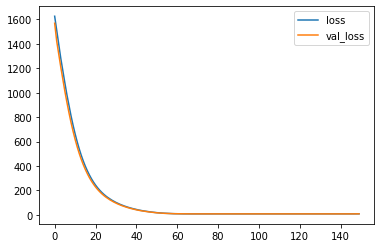

In [33]:
steps = [('feat', feat()), 
            ('dnn', DNN(epochs=150,batch_size=16,learning_rate=1e-3,
                l1_param=1e-2,l2_param=1e-2,validation_split=0.1,verbose=1,Q1f_=0.5))]
pipeline = Pipeline(steps)
ypred_ = pipeline.fit_predict(X_raw[0],zpca)

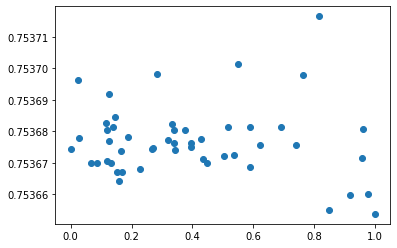

In [34]:
plt.scatter(zpca,ypred_)

In [20]:
# CORR pearson
a_ = np.concatenate(ypred_).T.tolist()#ypred
b_ = np.concatenate(zpca).T.tolist() #zpca
# spearmanr(a_,b_)
print(pearsonr(a_,b_))
# RMSE
RMSE_ = list()
for t in range(0,49):
  RMSE_.append((zpca[t]-ypred_[t])**2)
RMSE = np.sqrt(np.mean(np.asarray(RMSE_)))
RMSE

(0.7706145879287931, 5.956875753727466e-11)


0.2850499923142521

In [ ]:
# cv_ = LeaveOneOut()
# steps = [('feat', feat()),
#          ('dnn', DNN(epochs=150,batch_size=16,learning_rate=1e-3,
#                 l1_param=1e-2,l2_param=1e-2,validation_split=0.1,verbose=1,Q1f_=0.5))]
# pipeline = Pipeline(steps)
# tem_ypred = cross_val_predict(pipeline,X_raw[0],zpca,cv=cv_,verbose=10,n_jobs=2) #,n_jobs=2,method='predict'

Revisión de las predicciones

In [ ]:
# plt.hist(np.concatenate(tem_ypred).T.tolist())

In [ ]:
# plt.hist(zpca)

In [ ]:
# # CORR pearson
# a_ = np.concatenate(tem_ypred).T.tolist()#ypred

# b_ = np.concatenate(zpca).T.tolist() #zpca
# # spearmanr(a_,b_)
# print(pearsonr(a_,b_))
# # RMSE
# RMSE_ = list()
# for t in range(0,49):
#   RMSE_.append((zpca[t]-tem_ypred[t])**2)
# RMSE = np.sqrt(np.mean(np.asarray(RMSE_)))
# RMSE

In [ ]:
cv_ = LeaveOneOut()
ypred = list()                   # lista de predicción.
# aplicamos la validación por cada banda.
for Freq in range(0,1):#len(bands)): # Frecuencia de Analisis
    steps = [('feat', feat()),
         ('dnn', DNN(epochs=150,batch_size=16,learning_rate=1e-3,l1_param=1e-2,
                     l2_param=1e-2,validation_split=0.1,verbose=1,Q1f_=0.5))]
    pipeline = Pipeline(steps)
    tem_ypred = cross_val_predict(pipeline,X_raw[0],zpca,cv=cv_,verbose=10,n_jobs=2) #,n_jobs=2,method='predict'
    ypred.append(tem_ypred)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   25.7s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   47.3s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  4.1min


In [ ]:
# tf.keras.utils.plot_model(model)

Pearson

In [ ]:
Corr_pear_cor = list()
Corr_pear_pv = list()
for Freq in range(0,len(bands)): # Frecuencia de Analisis
    a_ = np.concatenate(ypred[Freq]).T.tolist()
    b_ = np.concatenate(zpca).T.tolist()#zpca
    [cor_pe,pv_pe]=pearsonr(a_,b_)
    Corr_pear_cor.append(cor_pe)
    Corr_pear_pv.append(pv_pe)

Spearman

In [ ]:
Corr_spear = list()
for Freq in range(0,len(bands)): # Frecuencia de Analisis
    a_ = np.concatenate(ypred[Freq]).T.tolist()#ypred
    b_ = np.concatenate(zpca).T.tolist() #zpca
    Corr_spear.append(spearmanr(a_,b_))

RMSE

In [ ]:
RMSE = list()
for Freq in range():
  RMSE_ = list()
  for t in range(0,50):
    RMSE_.append((zpca[t]-ypred[Freq][t])**2)
  RMSE.append(np.sqrt(np.mean(np.asarray(RMSE_))))    

Save data

In [ ]:
Data = {}
Data['Cv'] = cv_ 
Data['Corr_pear_cor'] = Corr_pear_cor
Data['Corr_pear_pv']  = Corr_pear_pv
Data['Corr_spearman'] = Corr_spear
Data['Ypred'] = ypred
Data['RMSE'] = RMSE
savemat('/content/drive/My Drive/DEEP LEARNING/prueba_deep_cx/Results/DNN_Conectividad.mat',{'Data':Data})

In [ ]:
# Estructura para guardar para python
# Date = {'Cv':cv_,'Corr_pearson':Corr_spear,'Corr_spearman':Corr_spear,'Ypred':ypred}
np.save('/content/drive/My Drive/DEEP LEARNING/prueba_deep_cx/Results/Npy/DNN_Conectividad.npy',Data)